In [43]:
import numpy as np
import pandas as pd

# Carregando o dataset e selecionando as colunas necessárias
dataset = pd.read_csv('../dataset/dados_pregao_dotz3.csv')
colunas = ['data_pregao', 'preco_ultimo_negocio']
data = dataset[colunas].copy()  # Usando .copy() para evitar problemas de referência

# Convertendo a coluna de data corretamente usando .loc
data.loc[:, 'data_pregao'] = pd.to_datetime(data['data_pregao'])

# Definindo a coluna de data como índice
data.set_index('data_pregao', inplace=True)

test_data = None
train_data = None
# Selecionando os últimos 30 pregões
test_data = data.tail(30)  # Últimos 30 registros (pregões)
train_data = data.iloc[:-30]  # Restante dos dados para treino

# Extraindo os valores das séries de treino e teste
train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

# Exibindo o dataframe completo (opcional)
data


,preco_ultimo_negocio
data_pregao,
2021-05-31,13.20
2021-06-01,13.18
2021-06-02,13.32
2021-06-04,13.14
2021-06-07,13.15
...,...
2024-10-01,4.80
2024-10-02,4.81
2024-10-03,4.89


30 DIAS

In [44]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [45]:
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

predictions = model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/100


c:\Users\suporte\Documents\Workspace\pregao_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 16.9949
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3598
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8197
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4074
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6609
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4626
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3803
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2904
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2912
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2889
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2418
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2994
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1457
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2087
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3386
Epoch 16/100
25

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Mean Squared Error (MSE): 0.1515803771635791
Root Mean Squared Error (RMSE): 0.38933324692810284
Mean Absolute Percentage Error (MAPE): 4.079900506417508%


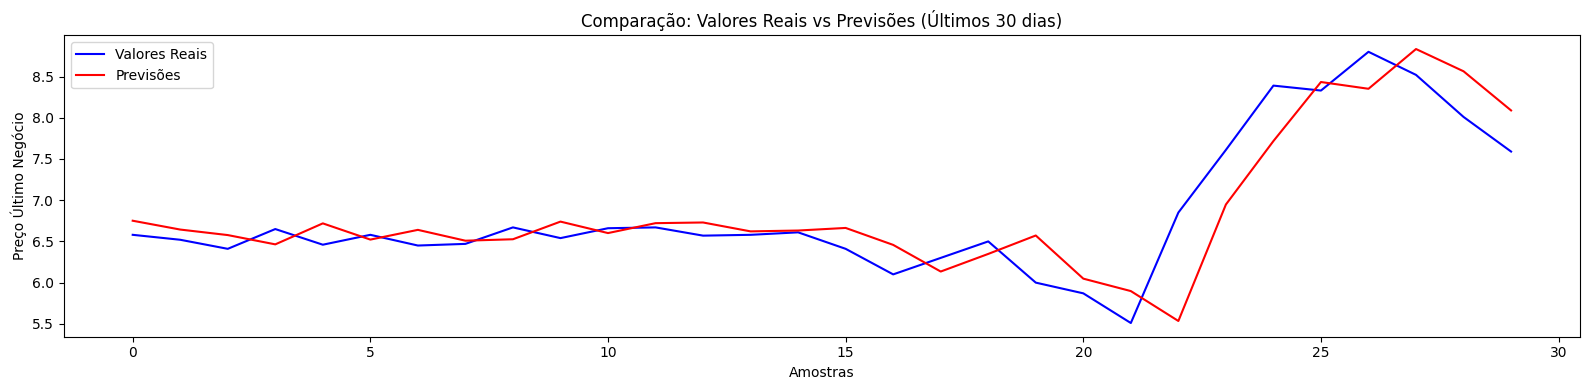

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraindo os últimos 30 dias do conjunto de treino
comparison_data = train_data.iloc[-60:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

# Criando sequências para o modelo prever
#sequence_length = 30  # Exemplo: sequências de 30 dias
X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

# Redimensionando para o formato de entrada esperado pelo LSTM
X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

# Realizando previsões para os últimos 90 dias
predictions = model.predict(X_test_sequences)

# Calculando as métricas MSE, RMSE e MAPE
mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Criando DataFrame para facilitar a comparação
results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

# Plotando a comparação entre os valores reais e as previsões
plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

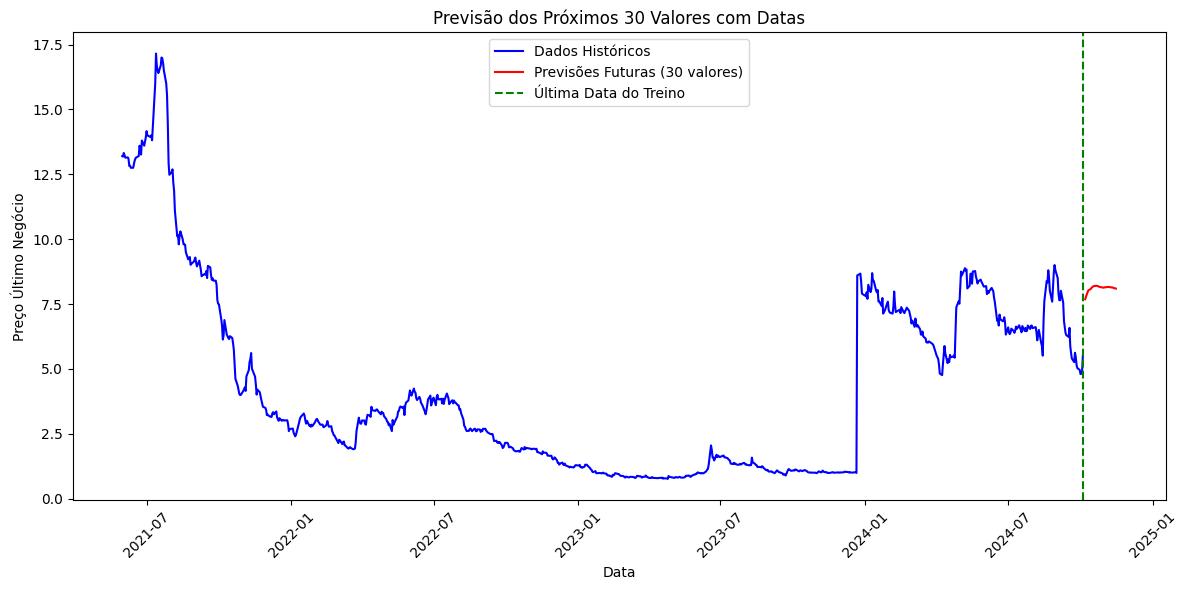

In [47]:
import matplotlib.pyplot as plt

last_sequence = train_data_values[-sequence_length:]  # Última sequência de treino
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(30):  # Prever os próximos 30 valores
    next_prediction = model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    # Atualizar a sequência atual para incluir a nova previsão
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

# Converter as previsões em um array unidimensional
future_predictions = np.array(future_predictions).flatten()

# Criar um DataFrame com as próximas 30 datas e os valores previstos
last_date = data.index[-1]  # Última data do conjunto de treino
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')  # Próximas 30 datas úteis

# Criar o DataFrame com as previsões e datas
future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

# Plotar os dados históricos e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (30 valores)', color='red')
plt.title('Previsão dos Próximos 30 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')  # Linha para a última data de treino
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

60 DIAS

In [48]:
test_data = None
train_data = None
# Selecionando os últimos 30 pregões
test_data = data.tail(60)
train_data = data.iloc[:-60]

# Extraindo os valores das séries de treino e teste
train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values


In [49]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [50]:
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

predictions = model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/100


c:\Users\suporte\Documents\Workspace\pregao_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 12.5920
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4556
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6916
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4266
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4080
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4003
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2713
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4398
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3261
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2856
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2669
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3825
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1261
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1155
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1780
Epoch 16/100
24

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean Squared Error (MSE): 0.09508369860214319
Root Mean Squared Error (RMSE): 0.3083564473172941
Mean Absolute Percentage Error (MAPE): 2.7383824638415173%


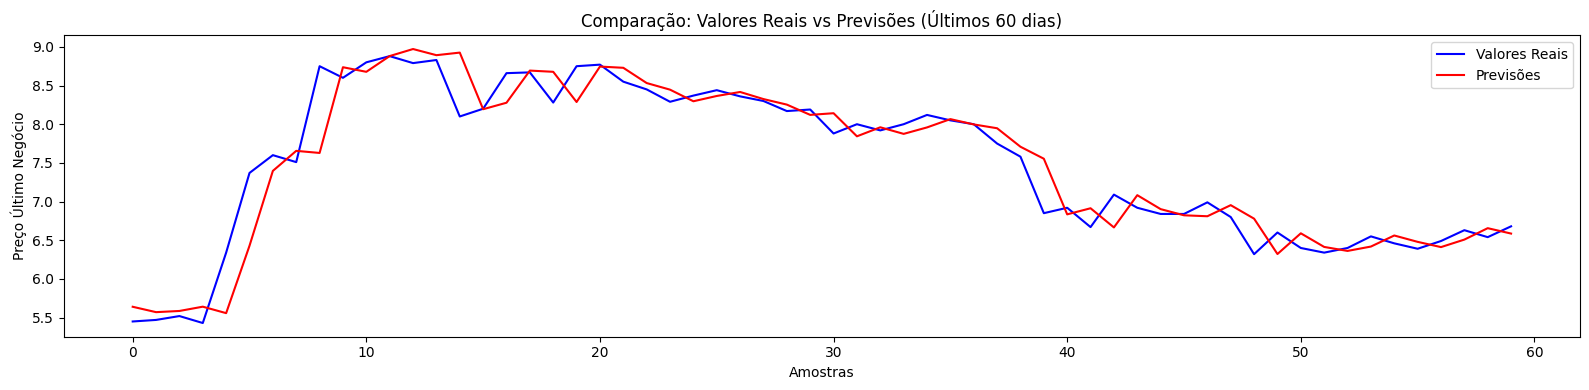

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraindo os últimos 90 dias do conjunto de treino
comparison_data = train_data.iloc[-90:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

# Criando sequências para o modelo prever
#sequence_length = 30  # Exemplo: sequências de 30 dias
X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

# Redimensionando para o formato de entrada esperado pelo LSTM
X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

# Realizando previsões para os últimos 90 dias
predictions = model.predict(X_test_sequences)

# Calculando as métricas MSE, RMSE e MAPE
mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Criando DataFrame para facilitar a comparação
results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

# Plotando a comparação entre os valores reais e as previsões
plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 60 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

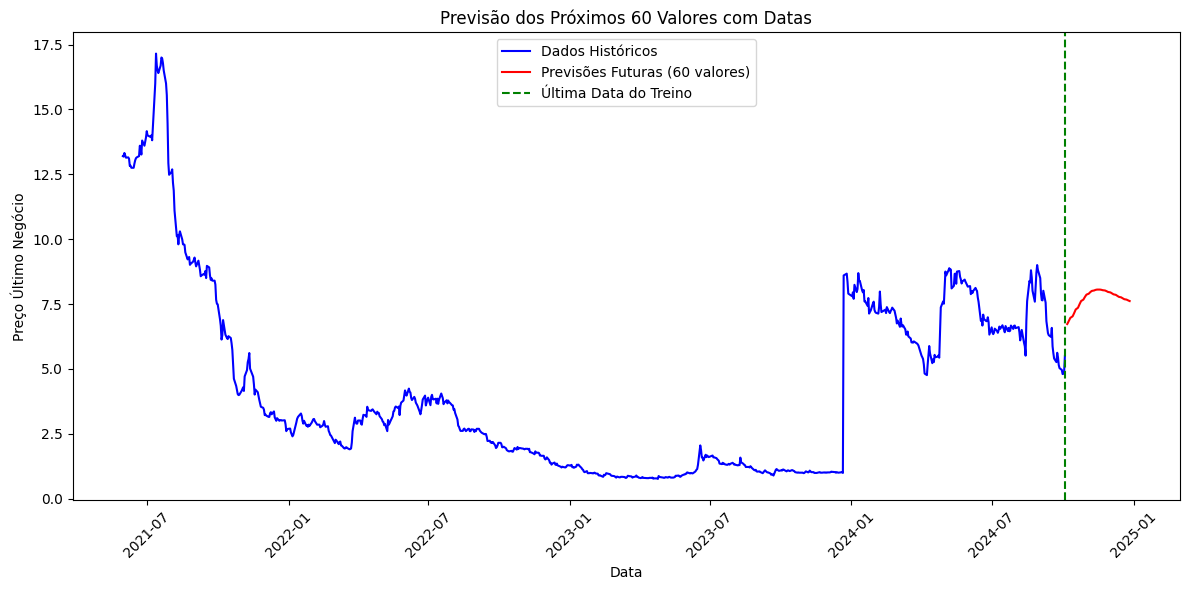

In [52]:
import matplotlib.pyplot as plt

last_sequence = train_data_values[-sequence_length:]  # Última sequência de treino
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(60):  # Prever os próximos 30 valores
    next_prediction = model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    # Atualizar a sequência atual para incluir a nova previsão
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

# Converter as previsões em um array unidimensional
future_predictions = np.array(future_predictions).flatten()

# Criar um DataFrame com as próximas 30 datas e os valores previstos
last_date = data.index[-1]  # Última data do conjunto de treino
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='B')  # Próximas 30 datas úteis

# Criar o DataFrame com as previsões e datas
future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

# Plotar os dados históricos e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (60 valores)', color='red')
plt.title('Previsão dos Próximos 60 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')  # Linha para a última data de treino
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

90 DIAS

In [53]:
test_data = None
train_data = None
# Selecionando os últimos 30 pregões
test_data = data.tail(90)
train_data = data.iloc[:-90]

# Extraindo os valores das séries de treino e teste
train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values


In [54]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  

In [55]:
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)

predictions = model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/100


c:\Users\suporte\Documents\Workspace\pregao_forecasting\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 13.6459
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4551
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7638
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7625
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4476
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3238
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1850
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1824
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2115
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3498
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0965
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1263
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2146
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1296
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1261


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error (MSE): 0.08989332707923653
Root Mean Squared Error (RMSE): 0.29982215908640997
Mean Absolute Percentage Error (MAPE): 2.891214334889251%


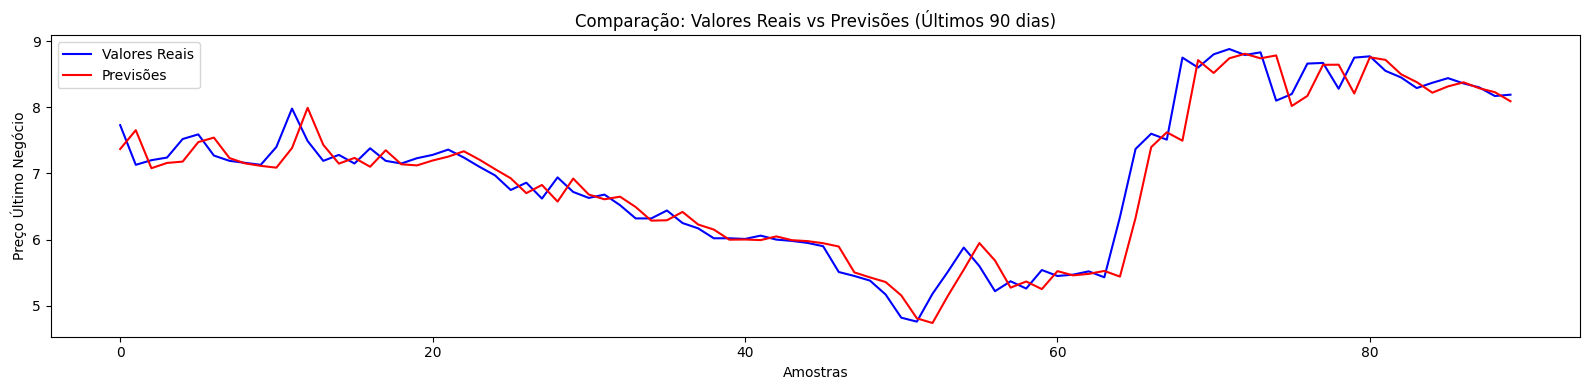

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extraindo os últimos 90 dias do conjunto de treino
comparison_data = train_data.iloc[-120:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

# Criando sequências para o modelo prever
#sequence_length = 30  # Exemplo: sequências de 30 dias
X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

# Redimensionando para o formato de entrada esperado pelo LSTM
X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

# Realizando previsões para os últimos 90 dias
predictions = model.predict(X_test_sequences)

# Calculando as métricas MSE, RMSE e MAPE
mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

# Evitando divisão por zero ao calcular o MAPE
non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

# Exibindo as métricas
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Criando DataFrame para facilitar a comparação
results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

# Plotando a comparação entre os valores reais e as previsões
plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 90 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

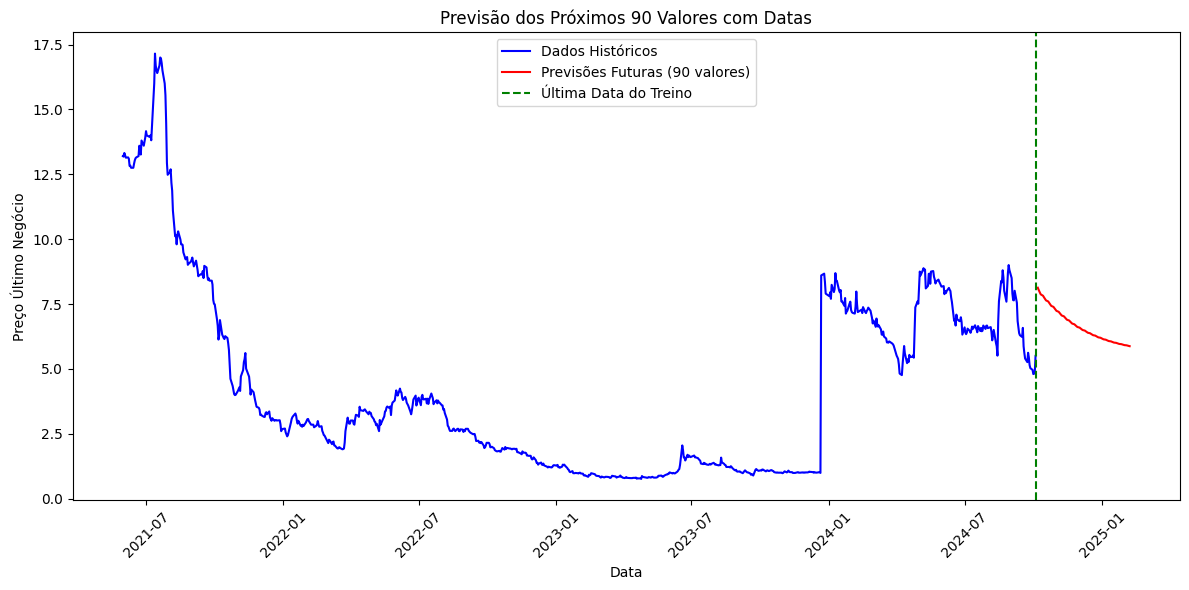

In [57]:
import matplotlib.pyplot as plt

last_sequence = train_data_values[-sequence_length:]  # Última sequência de treino
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(90):  # Prever os próximos 30 valores
    next_prediction = model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    # Atualizar a sequência atual para incluir a nova previsão
    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

# Converter as previsões em um array unidimensional
future_predictions = np.array(future_predictions).flatten()

# Criar um DataFrame com as próximas 30 datas e os valores previstos
last_date = data.index[-1]  # Última data do conjunto de treino
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')  # Próximas 30 datas úteis

# Criar o DataFrame com as previsões e datas
future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

# Plotar os dados históricos e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (90 valores)', color='red')
plt.title('Previsão dos Próximos 90 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')  # Linha para a última data de treino
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()